<div class="alert alert-block alert-info">
    <h2>Applied Stat Final Project Part 1</h2>
    <h3 style="text-decoration: underline;">Exploring Artwork History: A Data Science/Statistics/Machine Learning Approach</h3>
    <br>
    <b style="font-size: 20px;">Names:</b> <span style="font-size: 18px;">Ved Patel, Tejas Bhardwaj, Girish Ranganathan</span>
    <br>
</div>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Load the training dataset from a .npz file
trainingDataset = np.load('vgg16_train.npz')  # Load dataset containing 'logit' and 'year' arrays
logitData = trainingDataset['logit']          # Extract logit data
yearData = trainingDataset['year']            # Extract year data

# Compute the mean and center the logit data
meanLogitData = np.mean(logitData, axis=0)    # Calculate the mean for each feature across samples
centeredLogitData = logitData - meanLogitData # Center the data by subtracting the mean

# Compute the covariance matrix of the centered data
covarianceMatrix = np.cov(centeredLogitData, rowvar=False) # Covariance matrix (features as variables)

# Perform eigen decomposition to get eigenvalues and eigenvectors
eigenVals, eigenVecs = np.linalg.eigh(covarianceMatrix)    # Eigenvalues and eigenvectors of covariance matrix

# Whiten the data (decorrelate and normalize variances)
whitenedLogitData = np.dot(centeredLogitData, eigenVecs) / np.sqrt(eigenVals)

# Select the first principal component for 1D PCA
pca1DComponent = whitenedLogitData[:, -1]                  # Select the last (largest variance) component

# Select the first two principal components for 2D PCA
pca2DComponents = whitenedLogitData[:, -2:]                # Select the last two components

# Plot the 1D PCA against the year data
plt.figure()
plt.scatter(pca1DComponent, yearData, c=yearData, cmap='viridis', s=2) # Scatter plot with year as color
plt.colorbar(label='Year')                            # Add colorbar indicating year values
plt.title("Year over M=1 PCA")                        # Title of the plot
plt.xlabel("PCA Component 1")                         # Label for x-axis
plt.ylabel("Year")                                    # Label for y-axis
plt.show()                                            # Display the plot

# Create a 3D scatter plot for 2D PCA components and year data
fig = plt.figure()
ax = fig.add_subplot(projection='3d')                 # Set up 3D plotting
colorMap = mpl.cm.viridis                             # Define colormap (Viridis)
colorNorm = mpl.colors.Normalize(vmin=1148, vmax=2012) # Normalize year data for consistent coloring
fig.colorbar(mpl.cm.ScalarMappable(norm=colorNorm, cmap=colorMap), ax=plt.gca()) # Add colorbar
ax.scatter(pca2DComponents[:, 0],                     # X-axis: First PCA component
           pca2DComponents[:, 1],                     # Y-axis: Second PCA component
           yearData,                                  # Z-axis: Year data
           c=yearData, s=2)                           # Color and size settings
plt.title("Year over M=2 PCA")                        # Title of the plot
plt.show()                                            # Display the plot


In [33]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# Load training data from the .npz file
trainingData = np.load('vgg16_train.npz')  # Load the dataset
logitValues = trainingData['logit']        # Extract 'logit' features
yearValues = trainingData['year']          # Extract 'year' target values

# Transform the PCA features into polynomial features
polyTransformer = PolynomialFeatures(degree=2)          # Create polynomial feature transformer (degree=2)
transformedPcaFeatures = polyTransformer.fit_transform(pca2DComponents) # Apply the transformation

# Define a function to fit a polynomial model using least squares
def polynomialModelFit(X, y):
    return np.linalg.lstsq(X, y, rcond=None)[0]          # Solve the least squares problem for model coefficients

# Compute model coefficients for the polynomial model
modelCoefficients = polynomialModelFit(transformedPcaFeatures, yearValues)

# Define a function to make predictions using the polynomial model
def modelPredict(X, coeffs):
    return np.dot(X, coeffs)                             # Compute predictions as a dot product of features and coefficients

# Predict training target values using the polynomial model
predictedTrainValues = modelPredict(transformedPcaFeatures, modelCoefficients)

# Define a function to calculate mean squared error (MSE)
def calculateMse(actual, predicted):
    return np.mean((actual - predicted) ** 2)            # Compute average squared error between actual and predicted values

# Calculate the training MSE for the polynomial model
trainingMse = calculateMse(yearValues, predictedTrainValues) # Compute MSE for training data
print("Training MSE:", trainingMse)                           # Output the training MSE


Training MSE: 9776.837184479466


In [34]:
# Load test dataset from the .npz file
testData = np.load('vgg16_test.npz', allow_pickle=True)  # Load test data
testLogitData = testData['logit']                       # Extract 'logit' features from the test data
testYearData = testData['year']                         # Extract 'year' values (ground truth for testing)
testFileNames = testData['filename']                    # Extract filenames corresponding to the test data

# Center the test logit data using the mean from the training data
centeredTestLogits = testLogitData - meanLogitData      # Center test data by subtracting the training mean

# Reduce test data to the same PCA space (2D) using eigenvectors and eigenvalues
reducedTestPcaComponents = np.dot(centeredTestLogits, eigenVecs[:, -2:]) # Project data into top 2 PCA components
reducedTestPcaComponents /= np.sqrt(eigenVals[-2:])                      # Whiten the PCA components

# Transform reduced PCA features into polynomial features
transformedTestPcaFeatures = polyTransformer.fit_transform(reducedTestPcaComponents)

# Predict year values for the test data using the trained polynomial model
predictedTestYears = modelPredict(transformedTestPcaFeatures, modelCoefficients)

# Compute the test Mean Squared Error (MSE)
testMseError = calculateMse(testYearData, predictedTestYears)            # Calculate the MSE for test data
print("Test MSE:", testMseError)                                         # Print the test MSE

# Compute prediction errors and identify the best and worst predictions
predictionErrors = np.abs(predictedTestYears - testYearData)             # Absolute prediction errors
bestPredictionIndex = np.argmin(predictionErrors)                       # Index of the most accurate prediction
worstPredictionIndex = np.argmax(predictionErrors)                      # Index of the least accurate prediction

# Print filenames corresponding to the best and worst predictions
print(f"Most accurate prediction: {testFileNames[bestPredictionIndex]}")  # File with least error
print(f"Least accurate prediction: {testFileNames[worstPredictionIndex]}") # File with highest error


Test MSE: 9803.874918820336
Most accurate prediction: 921_the-angelus-1859.jpg
Least accurate prediction: 1803_untitled-holy-hole-1984.jpg


In [43]:
#Polynomail Regression with Various Degrees
for degree in range(1, 11):  # Iterate over polynomial degrees
    # Transform training data
    poly_transformer = PolynomialFeatures(degree=degree)
    transformed_train_features = poly_transformer.fit_transform(pca2DComponents)

    # Fit the model
    model_coeffs = polynomialModelFit(transformed_train_features, yearValues)

    # Predict on training data
    predicted_train_values = modelPredict(transformed_train_features, model_coeffs)
    train_mse = calculateMse(yearValues, predicted_train_values)

    # Transform test data
    transformed_test_features = poly_transformer.fit_transform(reducedTestPcaComponents)

    # Predict on test data
    predicted_test_values = modelPredict(transformed_test_features, model_coeffs)
    test_mse = calculateMse(testYearData, predicted_test_values)

    print(f"Degree {degree}, Training MSE: {train_mse}, Test MSE: {test_mse}")

Degree 1, Training MSE: 11860.422007194355, Test MSE: 12071.535147410608
Degree 2, Training MSE: 9776.837184479466, Test MSE: 9803.874918820336
Degree 3, Training MSE: 8525.445096576828, Test MSE: 8063.435180116439
Degree 4, Training MSE: 7497.650560375392, Test MSE: 7293.493417507487
Degree 5, Training MSE: 6757.552955870504, Test MSE: 6530.915683532492
Degree 6, Training MSE: 6432.48343576492, Test MSE: 6575.792454610773
Degree 7, Training MSE: 6036.294343246365, Test MSE: 6453.415439642564
Degree 8, Training MSE: 5809.163394940707, Test MSE: 5880.835038024897
Degree 9, Training MSE: 5651.032381022186, Test MSE: 7415.265426771036
Degree 10, Training MSE: 5676.02832187296, Test MSE: 8645.927875731117


In [36]:
from scipy.interpolate import splrep, splev
from sklearn.preprocessing import MinMaxScaler

# Normalize PCA components and year values to the range [0, 1]
scaler_pca = MinMaxScaler()                                   # Initialize scaler for PCA components
normalized_pca = scaler_pca.fit_transform(pca2DComponents)    # Normalize PCA components

scaler_year = MinMaxScaler()                                  # Initialize scaler for year values
normalized_years = scaler_year.fit_transform(yearValues.reshape(-1, 1)).flatten()  # Normalize year values

# Sort PCA components and corresponding year values for spline fitting
sorted_indices_x = np.argsort(normalized_pca[:, 0])           # Indices to sort by the first PCA component
sorted_x = normalized_pca[sorted_indices_x, 0]               # Sorted first PCA component
sorted_years_x = normalized_years[sorted_indices_x]          # Year values corresponding to sorted PCA component

sorted_indices_y = np.argsort(normalized_pca[:, 1])           # Indices to sort by the second PCA component
sorted_y = normalized_pca[sorted_indices_y, 1]               # Sorted second PCA component
sorted_years_y = normalized_years[sorted_indices_y]          # Year values corresponding to sorted PCA component

# Fit cubic splines (degree 3) with smoothing factor `s=43.0`
tck_x = splrep(sorted_x, sorted_years_x, s=43.0, k=3)         # Fit spline for the first PCA component
tck_y = splrep(sorted_y, sorted_years_y, s=43.0, k=3)         # Fit spline for the second PCA component

# Evaluate spline predictions for the normalized PCA components
spline_predictions_x = splev(normalized_pca[:, 0], tck_x)     # Predict using the spline fitted to the first PCA component
spline_predictions_y = splev(normalized_pca[:, 1], tck_y)     # Predict using the spline fitted to the second PCA component

# Combine predictions by averaging the two spline outputs
spline_predictions = (spline_predictions_x + spline_predictions_y) / 2

# Rescale the averaged spline predictions back to the original year range
rescaled_predictions = scaler_year.inverse_transform(spline_predictions.reshape(-1, 1)).flatten()

# Calculate Mean Squared Error (MSE) for the spline predictions
mse_spline = calculateMse(yearValues, rescaled_predictions)   # Compare rescaled predictions to actual year values
print(f"Spline Regression MSE (Alternative Method): {mse_spline}")  # Print the MSE for spline regression


Spline Regression MSE (Alternative Method): 4077.829539715892


In [37]:
from sklearn.utils import resample

# Initialize an empty list to store MSEs from bootstrap samples
bootstrap_mses = []
n_iterations = 100  # Number of bootstrap iterations

for i in range(n_iterations):
    # Resample the data with replacement
    resampled_features, resampled_years = resample(
        transformed_features, yearValues, random_state=i
    )
    
    # Fit a polynomial model using the resampled dataset
    resampled_coeffs = polynomialModelFit(resampled_features, resampled_years)
    
    # Use the model to predict on the original dataset
    resampled_predictions = modelPredict(transformed_features, resampled_coeffs)
    
    # Calculate Mean Squared Error (MSE) on the original dataset
    mse = calculateMse(yearValues, resampled_predictions)
    bootstrap_mses.append(mse)  # Append the MSE to the list

# Convert the list of MSEs to a NumPy array for easier calculations
bootstrap_mses = np.array(bootstrap_mses)

# Calculate the mean and 95% confidence intervals for the bootstrap MSEs
print(f"Bootstrap MSE: Mean={np.mean(bootstrap_mses)}, 95% CI=({np.percentile(bootstrap_mses, 2.5)}, {np.percentile(bootstrap_mses, 97.5)})")


Bootstrap MSE: Mean=1306711.145581894, 95% CI=(6779.746232246565, 13585696.232994609)


In [38]:
# Identify columns with zero variance
non_constant_columns = np.std(transformed_features, axis=0) > 0

# Filter out constant features
filtered_features = transformed_features[:, non_constant_columns]
print(f"Number of non-constant features: {filtered_features.shape[1]}")

Number of non-constant features: 20


In [39]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import linregress

# Initialize an empty list to store p-values
p_values = []

# Iterate through each feature in the filtered features
for i in range(filtered_features.shape[1]):
    feature = filtered_features[:, i]  # Select the i-th feature
    # Perform linear regression between the feature and the target (yearValues)
    slope, intercept, r_value, p_value, std_err = linregress(feature, yearValues)
    p_values.append(p_value)  # Append the computed p-value

# Convert p-values list to a numpy array
p_values = np.array(p_values)

# Apply FDR control using Benjamini-Hochberg
_, corrected_p_values, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

# Select features below the FDR threshold
selected_features = filtered_features[:, corrected_p_values < 0.05]
print(f"Selected features after FDR control: {selected_features.shape[1]}")


Selected features after FDR control: 13


In [ ]:
plt.figure()
for degree in range(1, 6):
    plt.plot(pca2DComponents[:, 0], modelPredict(poly_transformer
                                                 .fit_transform(pca2DComponents), model_coeffs), label=f'Degree {degree}')
plt.legend()
plt.xlabel("PCA Component 1")
plt.ylabel("Year")
plt.title("Polynomial Regression Comparisons")
plt.show()


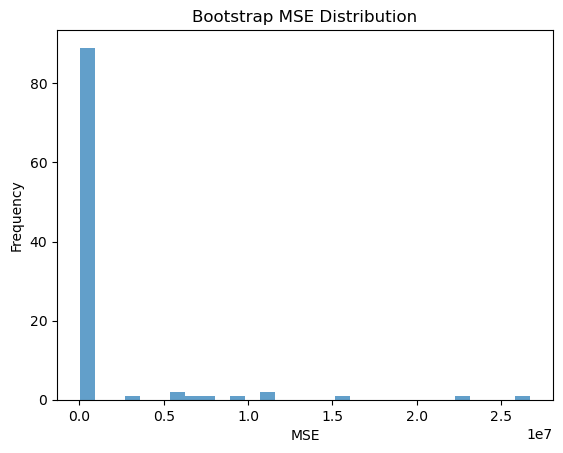

In [41]:
plt.hist(bootstrap_mses, bins=30, alpha=0.7)
plt.title("Bootstrap MSE Distribution")
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.show()
